# Protein-Protein Interaction
This notebook describes the necessary steps for the protein-protein interaction network for all the genes in our reconstruction

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import pickle
from google_sheet import GoogleSheet

# Data Fetching
import requests
import json
from pp_interactions import fetch_string_interactions, visualize_network

# Plotting
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
##### ----- Generate datasets from Google Sheet ----- #####

KEY_FILE_PATH = 'credentials.json'
SPREADSHEET_ID = '1DaAdZlvMYDqb7g31I5dw-ZCZH52Xj_W3FnQMFUzqmiQ'
gsheet_file = GoogleSheet(SPREADSHEET_ID, KEY_FILE_PATH)
sec_recon_sheet = 'SecRecon'
secrecon = gsheet_file.read_google_sheet(sec_recon_sheet)

In [3]:
# Load Reconstruction

gene_dict_path = 'gene_dict.pkl'
with open(gene_dict_path, 'rb') as file:
    gene_dict = pickle.load(file)

# Create gene_list
gene_list = list(gene_dict.keys())

### 1.STRINGS - Sec Recon

In [4]:
G_string = fetch_string_interactions(gene_list)

# Save the network generated
nx.write_graphml(G_string, 'Network/string_interactions_sec_recon.graphml')

Fetching Interactions:  33%|█████▌           | 368/1130 [02:04<03:40,  3.45it/s]

No interaction found for HSP90AA4P


Fetching Interactions:  33%|█████▌           | 369/1130 [02:04<05:14,  2.42it/s]

No interaction found for HSP90AA5P


Fetching Interactions:  33%|█████▌           | 371/1130 [02:05<05:26,  2.32it/s]

No interaction found for HSP90AB2P


Fetching Interactions:  33%|█████▌           | 372/1130 [02:06<04:48,  2.63it/s]

No interaction found for HSP90AB3P


Fetching Interactions:  33%|█████▌           | 373/1130 [02:06<04:16,  2.95it/s]

No interaction found for HSP90AB4P


Fetching Interactions: 100%|████████████████| 1130/1130 [06:26<00:00,  2.92it/s]


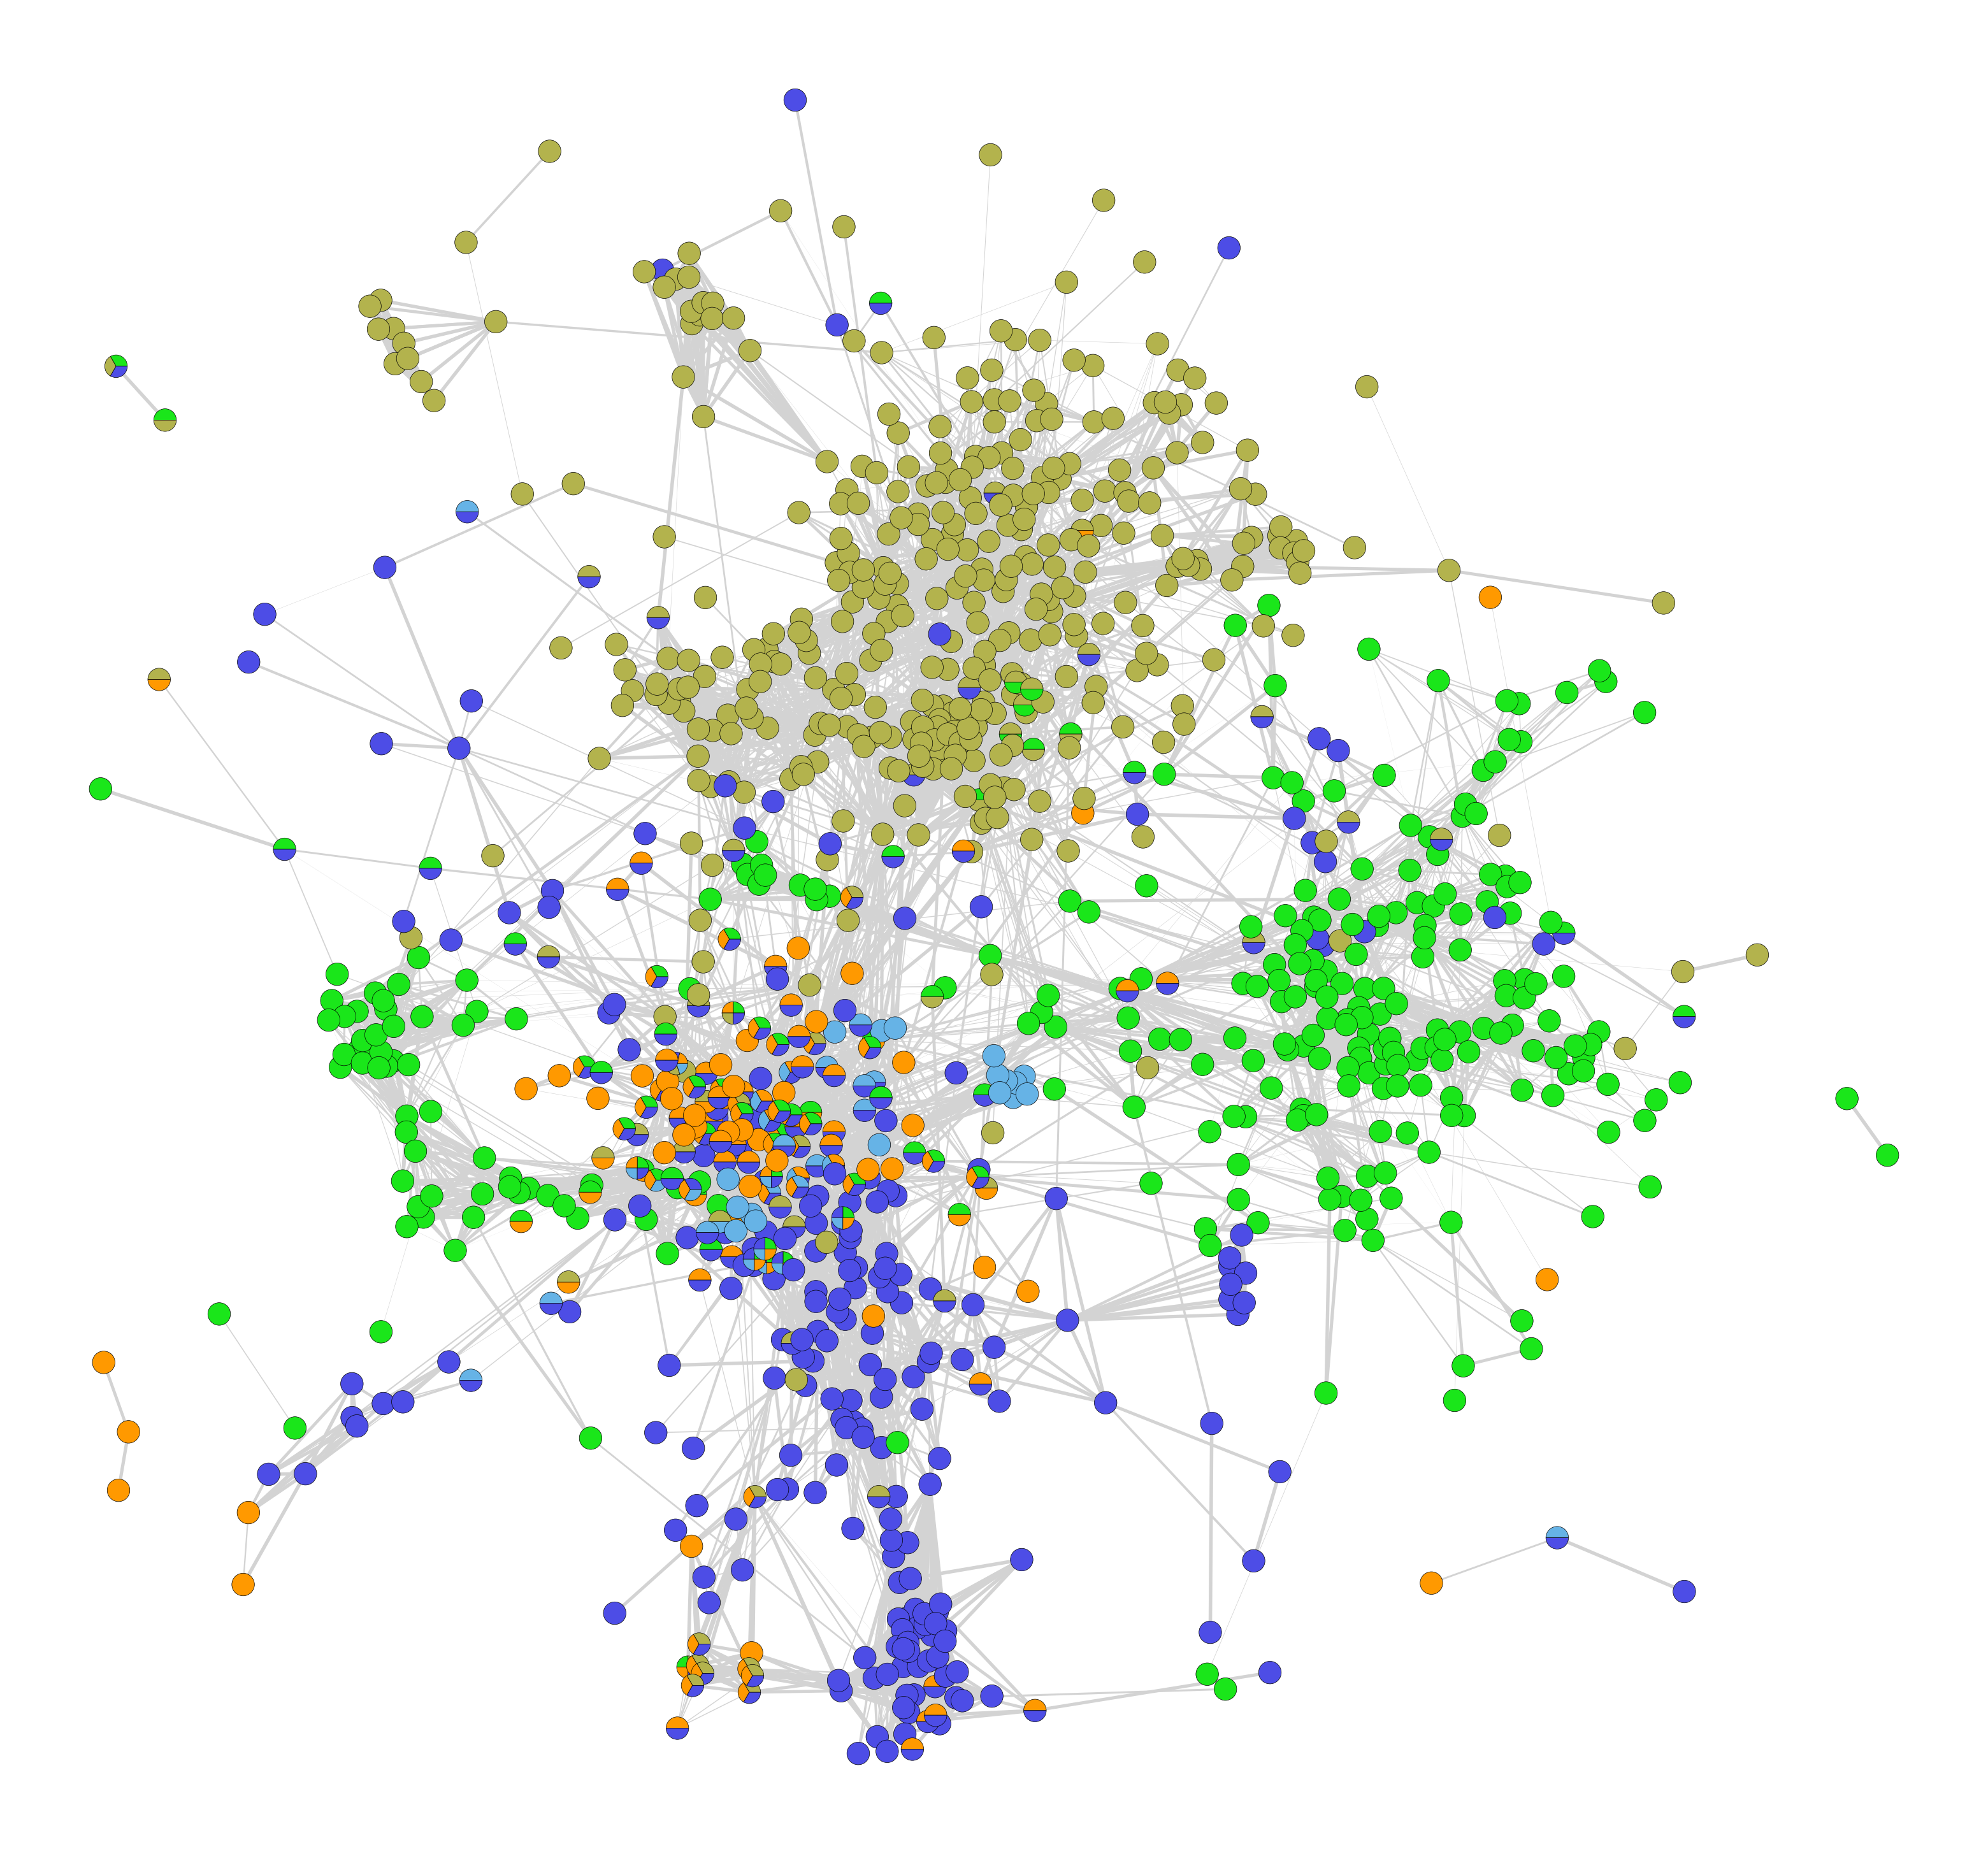

In [5]:
#G_string = nx.read_graphml('Network/string_interactions_sec_recon.graphml')
filename = f"Network/STRING_interactions_localizationcolor.png"
visualize_network(G=G_string, node_size=0.012, filename=filename, color_by='systems', gene_dict=gene_dict, legends=False) 

### 1.2 STRINGS - Sec Recon + Human Secretome

In [16]:
# Load Human Secretome df
human_secretome = pd.read_excel('Input/human_secretome.xlsx')
# Subset of all the secreted proteins
human_secretome = human_secretome[human_secretome['Annotated category'].str.contains('secreted', case=False)]
human_secretome_list = list(human_secretome_dict.keys())

In [17]:
# Creating the dictionary
human_secretome_dict = {row['Gene name']: {'systems': ['Secreted'], 'subcellular_localization': ['Secreted']} for index, row in human_secretome.iterrows()}

In [18]:
# Merging human secretome dictionary with gene_dict
gene_sec_dict = gene_dict.copy()

for key, value in human_secretome_dict.items():
    if key not in gene_sec_dict:
        gene_sec_dict[key] = value

In [19]:
G_string = fetch_string_interactions(gene_list, extra_genes=human_secretome_list)

# Save the network generated
nx.write_graphml(G_string, 'Network/string_interactions_sec_recon_plus_secretome.graphml')

Fetching Interactions:  33%|█████▌           | 368/1130 [02:03<03:09,  4.02it/s]

No interaction found for HSP90AA4P


Fetching Interactions:  33%|█████▌           | 369/1130 [02:03<03:21,  3.78it/s]

No interaction found for HSP90AA5P


Fetching Interactions:  33%|█████▌           | 371/1130 [02:04<03:15,  3.89it/s]

No interaction found for HSP90AB2P


Fetching Interactions:  33%|█████▌           | 372/1130 [02:04<03:10,  3.98it/s]

No interaction found for HSP90AB3P


Fetching Interactions:  33%|█████▌           | 373/1130 [02:04<03:08,  4.03it/s]

No interaction found for HSP90AB4P


Fetching Interactions: 100%|████████████████| 1130/1130 [06:15<00:00,  3.01it/s]


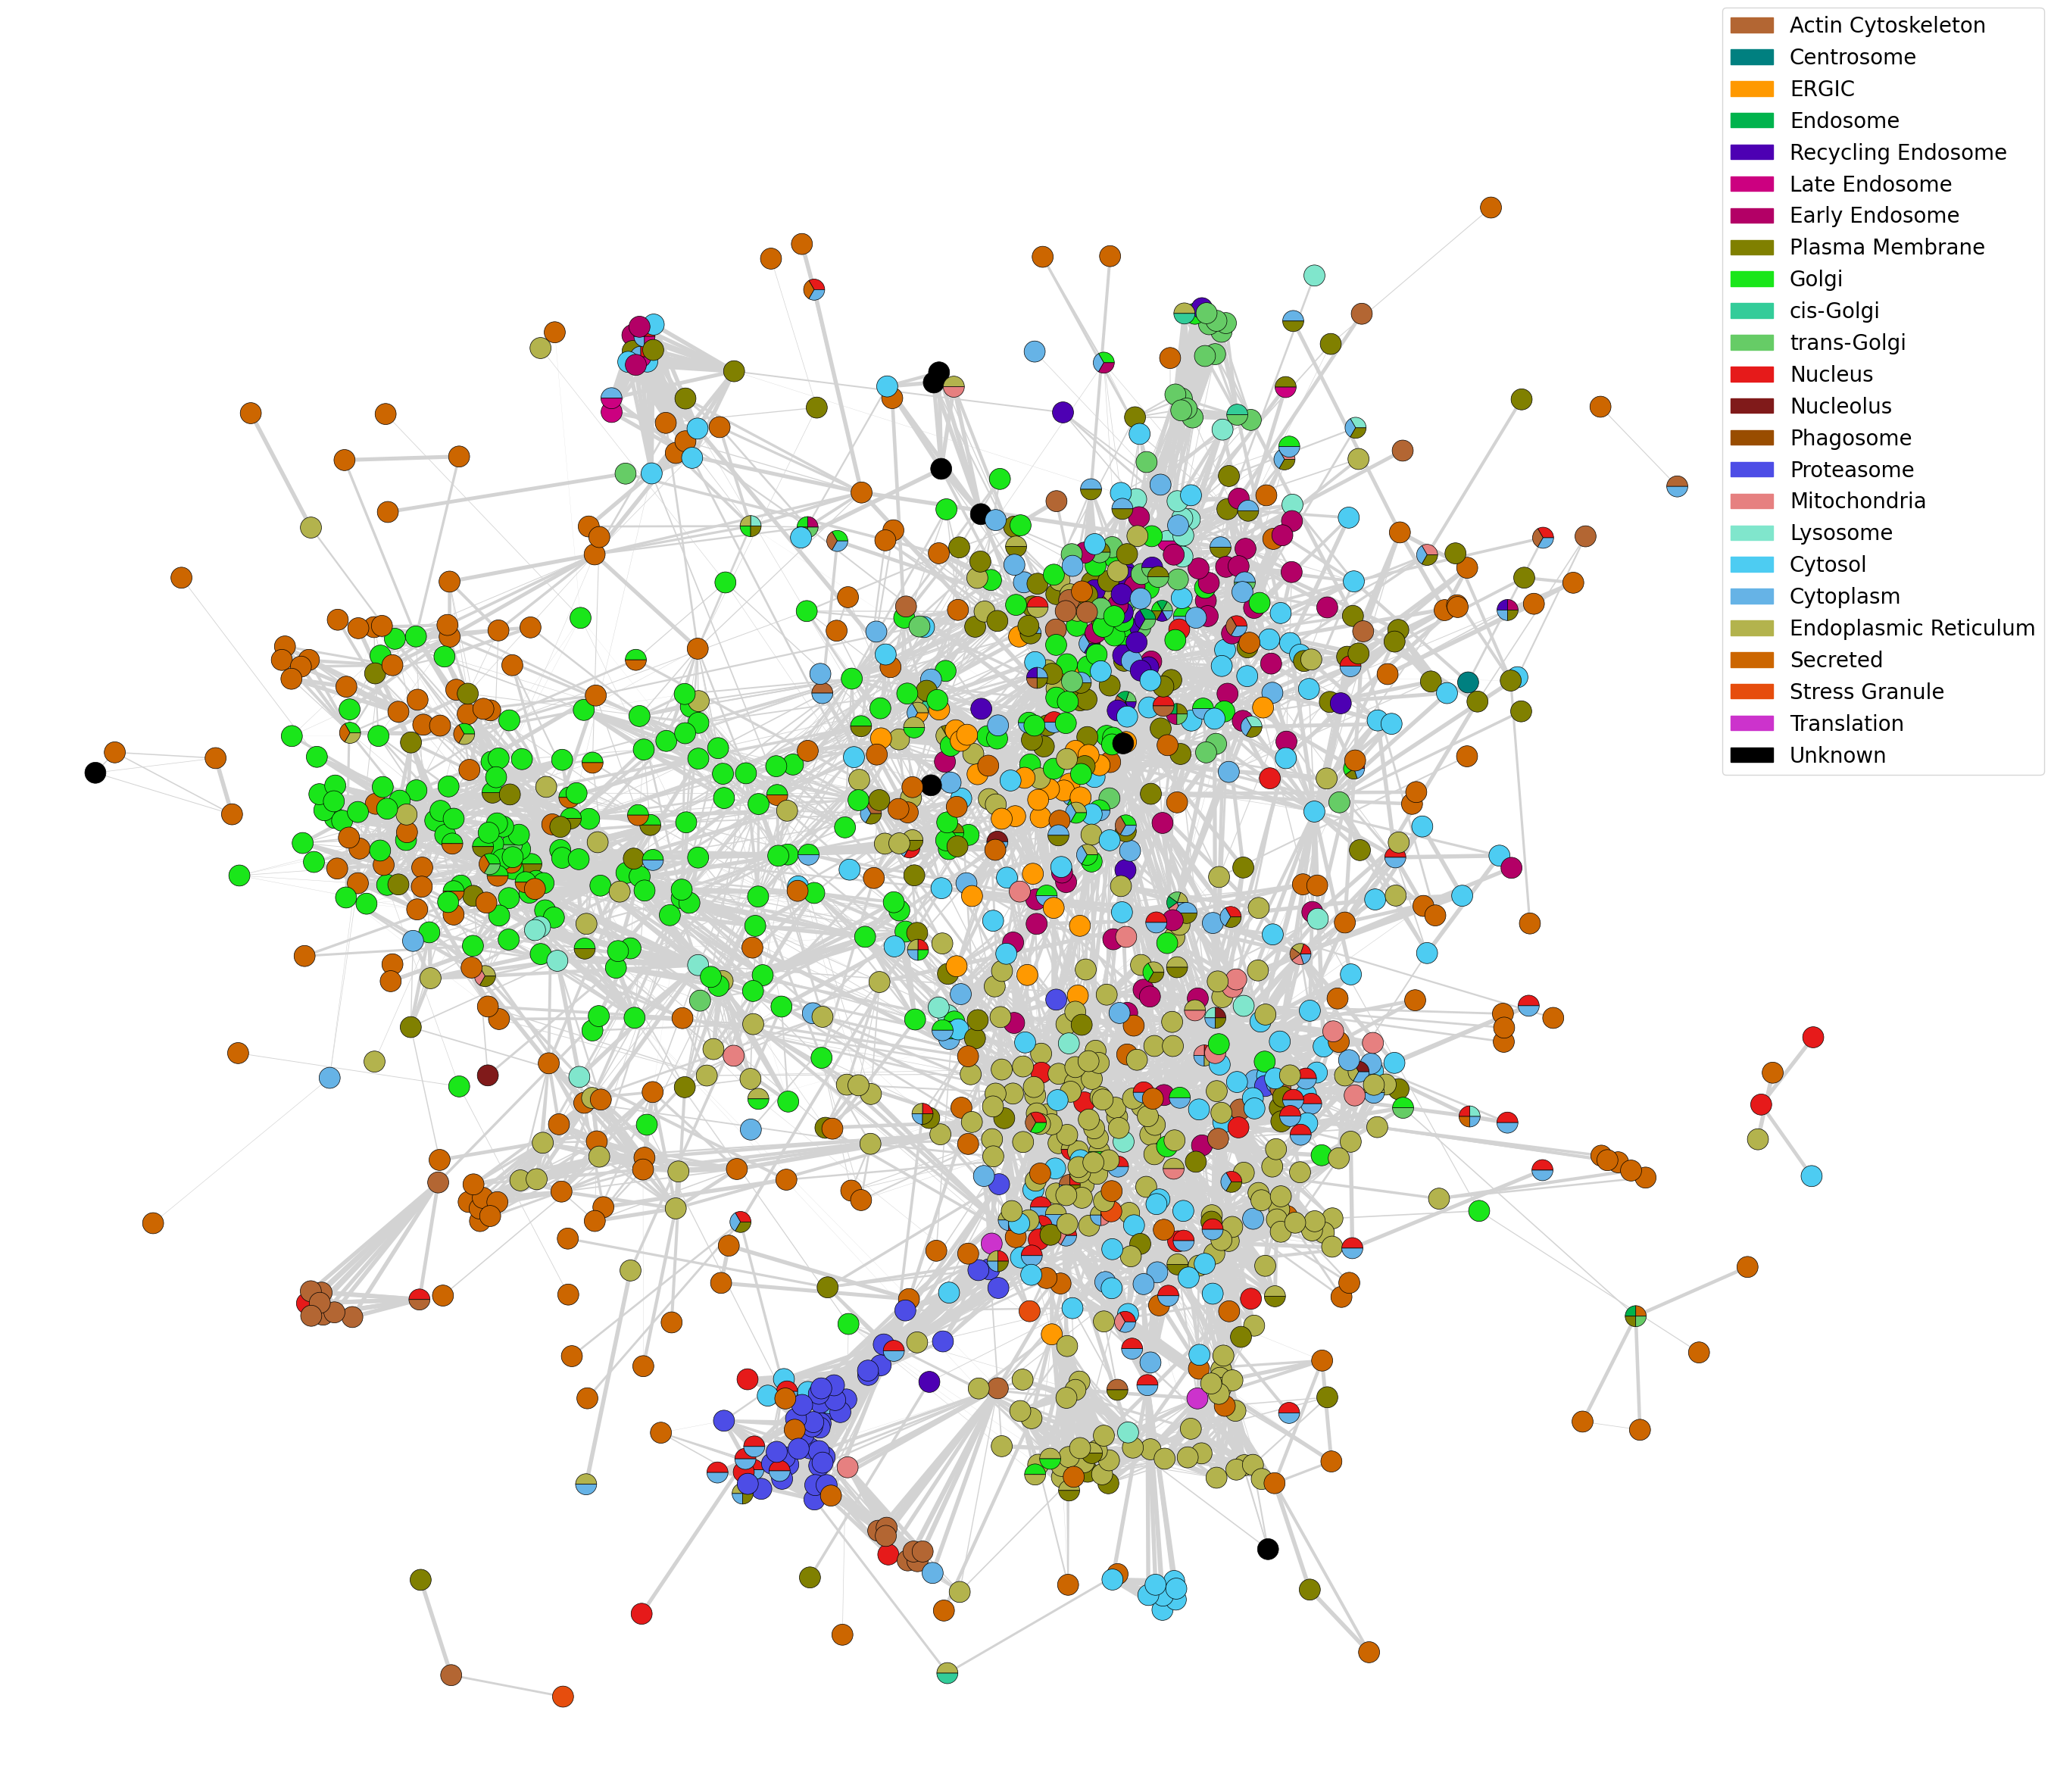

In [28]:
color_code = 'localization' #systems

#G_string = nx.read_graphml('Network/string_interactions_sec_recon_plus_secretome.graphml') # Uncoment if reading the G object
filename = f"Network/STRING_interactions_secrecon_secretome_{color_code}.png"
visualize_network(G=G_string, node_size=0.010, filename=filename, dist=0.15, color_by=color_code, gene_dict=gene_sec_dict, legends=True) 

### 1.3 STRINGS - Sec Recon divided by Systems + Human Secretome

In [ ]:
# Criteria for subsetting
criteria = [
    'Protein conformation',
    'Post-translational modifications',
    'Proteostasis',
    'Translocation',
    'Vesicle trafficking'
]

# Initialize empty dictionaries for each criteria
subset_dicts = {criterion: {} for criterion in criteria}

# Iterate through the original dictionary and apply the criteria
for protein, details in gene_sec_dict.items():
    for criterion in criteria:
        if criterion in details['systems'] or 'Secreted' in details['systems']:
            subset_dicts[criterion][protein] = details

In [ ]:
proteostasis = subset_dicts['Proteostasis']

In [ ]:
G_string = fetch_string_interactions(proteostasis)

# Save the network generated
#nx.write_graphml(G_string, 'Network/string_interactions_sec_recon_plus_secretome.graphml')

In [ ]:
color_code = 'localization' #systems

G_string = nx.read_graphml('Network/string_interactions_sec_recon_plus_secretome.graphml') # Uncoment if reading the G object
filename = f"Network/STRING_interactions_proteostasis_secretome_{color_code}.png"
visualize_network(G=G_string, node_size=0.012, filename=filename, dist=0.15, color_by=color_code, gene_dict=gene_sec_dict, legends=False) 

### 2.PrePPI
For this part, create a python dict with the uniprot IDs from secrecon as keys and the gene symbols as values, then mapped those gene symbols to the preppi database.

https://www.sciencedirect.com/science/article/pii/S0022283623001080?via%3Dihub
https://honiglab.c2b2.columbia.edu/PrePPI/

In [4]:
# Initialize an empty dictionary to store the UniProt ID as key and the Gene Symbol as value
uniprot_gene_dict = {}

# Iterate through each row in the DataFrame
for index, row in secrecon.iterrows():
    # Check if the UniProt field is not None or NaN
    if pd.notna(row['HUMAN UNIPROT']):
        # Split the UniProt IDs by comma
        uniprot_ids = row['HUMAN UNIPROT'].split(',')
        # Map each UniProt ID to the gene symbol
        for uniprot_id in uniprot_ids:
            uniprot_gene_dict[uniprot_id.strip()] = row['GENE SYMBOL']

In [6]:
preppi_file_path = 'Input/preppi_interactome/preppi.human_af.interactome.txt'
preppi_df = pd.read_csv(preppi_file_path, sep='\t')

In [7]:
preppi_df

prot1   prot2  str_score  protpep_score  str_max_score  red_score  \
0        Q9H9F9  A5A3E0       0.00        3.52956      130.17010     0.9127   
1        Q13131  P14625       0.87        6.44772        6.44772     4.2492   
2        P06400  Q96N96       0.27       14.32220       14.32220     0.0000   
3        Q6GYQ0  Q92529       0.00       20.62620       20.62620     0.0000   
4        Q9C0D4  Q96HQ0     481.96        0.00000      481.96000     0.0000   
...         ...     ...        ...            ...            ...        ...   
1393603  P53367  Q68EM7       0.00        0.00000       35.16680     1.2535   
1393604  Q9NVR0  Q9P2G3     503.55        0.00000      503.55000     0.0000   
1393605  O75346  Q969W8     140.89        0.00000      140.89000     0.0000   
1393606  P18089  P48431       0.57        0.00000        0.57000     4.2492   
1393607  P01614  O43897     140.89        0.00000      140.89000     0.0000   

         ort_score  phy_score  coexp_score  go_score  total_score template  \
0           0.6153     2.0130       1.1757      0.00   173.008124      NaN   
1           0.6153     2.4160       9.4687     10.80  4164.964458  6xlg:AC   
2           0.0000     2.4160       2.1077     10.80   787.660769  5vsu:HD   
3           0.0000     2.4160       3.9008      5.86  1139.114695      NaN   
4           0.0000     2.0130       2.1077      0.00  2044.859936  5v3g:GA   
...            ...        ...          ...       ...          ...      ...   
1393603     0.0000     2.4160       3.9008      5.86  2434.475564      NaN   
1393604     0.0000     2.4160       1.5818      0.00  1924.381182  7lzr:DC   
1393605     5.5574     0.9930       9.4687      0.89  6552.113891  5v3g:AG   
1393606     0.0000     2.0130       2.7714    105.17  1421.074642  1f5t:AB   
1393607     0.0000     1.5978       0.4364      0.00    98.239768  2qqk:AL   

         pdb  dbs  
0        NaN  NaN  
1        NaN  NaN  
2        NaN  NaN  
3        NaN  NaN  
4        NaN  NaN  
...      ...  ...  
1393603  NaN  NaN  
1393604  NaN  NaN  
1393605  NaN  NaN  
1393606  NaN  NaN  
1393607  NaN  NaN  

[1393608 rows x 14 columns]

In [8]:
# Map 'prot1' and 'prot2' using the dictionary
preppi_df['prot1_gene_symbol'] = preppi_df['prot1'].map(uniprot_gene_dict)
preppi_df['prot2_gene_symbol'] = preppi_df['prot2'].map(uniprot_gene_dict)

In [9]:
filtered_df = preppi_df.dropna(subset=['prot1_gene_symbol', 'prot2_gene_symbol'])

In [10]:
filtered_df = preppi_df.dropna(subset=['prot1_gene_symbol', 'prot2_gene_symbol'])

In [11]:
filtered_df

prot1   prot2  str_score  protpep_score  str_max_score  red_score  \
73       Q96P47  Q8TDY4      54.97       14.07530       54.97000     0.0000   
86       A5LHX3  Q9UL46       0.00        0.00000       33.11430     3.7695   
102      P31749  Q8TAT6       5.50        6.70870        6.70870     0.0000   
157      P53367  O60499      10.89        0.00000       10.89000     0.0000   
208      Q13618  P46459       0.52        2.60197        2.60197    19.2898   
...         ...     ...        ...            ...            ...        ...   
1392866  O75460  Q9UPU7       0.87        5.45912        5.45912     0.0000   
1393043  O95249  Q15437       0.66        3.67486        3.67486     0.9127   
1393198  Q9Y678  Q99747       0.27        3.86531        3.86531     0.0000   
1393268  P55072  O43617       0.22        0.00000        0.22000    19.2898   
1393486  Q9Y6Q5  P57735      12.40        3.52956       12.40000     0.5125   

         ort_score  phy_score  coexp_score  go_score   total_score template  \
73          0.6153     2.4160       2.7714     69.61  15764.508259  2b0o:EF   
86          0.6153     2.4160       1.5818      5.86   1720.015493      NaN   
102         0.6153     2.4160       9.4687     10.80   1019.850067  6uyj:AD   
157         0.0000     2.4160       2.7714      5.86    427.288927  5l8g:DE   
208         0.6153     2.0130      18.4426      2.07   2373.303022  7jpo:EA   
...            ...        ...          ...       ...           ...      ...   
1392866     0.6153     2.4160       9.4687      5.86    450.292236  3g7i:BA   
1393043     0.0000     2.4160       5.6875     69.61   3208.180705  2odm:BA   
1393198     0.0000     2.4160       9.4687     10.80    954.982411  4npq:JF   
1393268     0.6153     1.5978      45.2798     69.61  13150.306379  2wb1:LB   
1393486     0.6153     2.0130      45.2798      2.07    737.770168  6cm9:HM   

         pdb    dbs prot1_gene_symbol prot2_gene_symbol  
73       NaN    NaN             AGAP3             ASAP3  
86       NaN    NaN            PSMB11             PSME2  
102      NaN    NaN              AKT1            NPLOC4  
157      NaN    NaN            ARFIP1             STX10  
208      NaN  APID,              CUL3               NSF  
...      ...    ...               ...               ...  
1392866  NaN    NaN              ERN1           TBC1D2B  
1393043  NaN    NaN             GOSR1            SEC23B  
1393198  NaN    NaN             COPG1              NAPG  
1393268  NaN    NaN               VCP           TRAPPC3  
1393486  NaN    NaN             AP1M2             RAB25  

[21901 rows x 16 columns]

In [12]:
# Initialize an empty graph
G_preppi = nx.Graph()

seen_interactions = set()

for i,row in filtered_df.iterrows():
    protein1 = row['prot1_gene_symbol']
    protein2 = row['prot2_gene_symbol']
    interaction_tuple = (protein1, protein2)
    # Remove proteins interacting with themselves
    if protein1 != protein2:
        # Check if interaction is already seen, considering both directions
        if interaction_tuple not in seen_interactions and (protein2, protein1) not in seen_interactions:
            score = row['total_score']
            # Add nodes and edges to the graph if interaction is new
            G_preppi.add_node(protein1)
            G_preppi.add_node(protein2)
            G_preppi.add_edge(protein1, protein2, weight=score)
            # Add to seen interactions in both orders
            seen_interactions.add(interaction_tuple)
            seen_interactions.add((protein2, protein1))

In [32]:


def visualize_network(G, main_genes=None, node_size=0.010, filename=None,dist=0.15, itrs=80, color_by='systems', gene_dict=dict, legends=True):
    """
    Visualize a protein-protein interaction network using matplotlib.
    
    Parameters:
    - G (networkx.Graph): The graph to visualize.
    - main_genes (list, optional): List of gene names for the title.
    - node_size (int, optional): Size of the nodes.
    - labels_size (int, optional): Font size for labels.
    - filename (str, optional): If provided, save the plot to this filename.
    """

    system_colors = {
    'Protein conformation': (1.0, 0.6, 0.0, 1.0),
    'Post-translational modifications': (0.1, 0.9, 0.1, 1.0), 
    'Proteostasis': (0.3, 0.3, 0.9, 1.0),
    'Translocation': (0.4, 0.7, 0.9, 1.0),
    'Vesicle trafficking': (0.7, 0.7, 0.3, 1.0),
    'Secreted': (0.9, 0.1, 0.1, 1.0)
    }
    # Scale edge widths
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    min_width = 0.1
    max_width = 0.9
    epsilon = 1e-10
    edge_weights = [min_width + (w - min(edge_weights)) * (max_width - min_width) / (max(edge_weights) - min(edge_weights) + epsilon) for w in edge_weights]
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(40, 40))
    
    # Draw the network
    pos = nx.spring_layout(G, seed=42, k=dist, iterations=itrs)
    
    
    # Draw edges with scaled widths
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='lightgray', ax=ax)

    # Draw nodes as pie charts
    if color_by == 'systems':
        for node, (x, y) in pos.items():
            systems = gene_dict[node]['systems']
            colors = [system_colors[sys] for sys in systems]
            ax.pie([1]*len(systems), colors=colors, radius=node_size, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))

    elif color_by == 'localization':
        for node, (x, y) in pos.items():
            localizations = gene_dict[node]['subcellular_localization']
            colors = [localization_colors[loc] for loc in localizations]
            ax.pie([1]*len(localizations), colors=colors, radius=0.012, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
    
    # Get the current axis limits
    x_values, y_values = zip(*pos.values())
    min_x, max_x = min(x_values), max(x_values)
    min_y, max_y = min(y_values), max(y_values)
    
    # Set new axis limits
    ax.set_xlim(min_x - 0.1, max_x + 0.1)
    ax.set_ylim(min_y - 0.1, max_y + 0.1)

    # Legend
    if legends:
        if color_by == 'systems':
            legend_patches = [mpatches.Patch(color=color, label=category) for category, color in system_colors.items()]
            plt.legend(handles=legend_patches, prop={'size': 25}, loc='lower left', bbox_to_anchor=(0.9, 0.6))
            plt.subplots_adjust(right=0.75)
        elif color_by == 'localization':
            legend_patches = [mpatches.Patch(color=color, label=category) for category, color in localization_colors.items()]
            plt.legend(handles=legend_patches, prop={'size': 20}, loc='lower left', bbox_to_anchor=(0.9, 0.6))
            plt.subplots_adjust(right=0.75)
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
         
    plt.show()

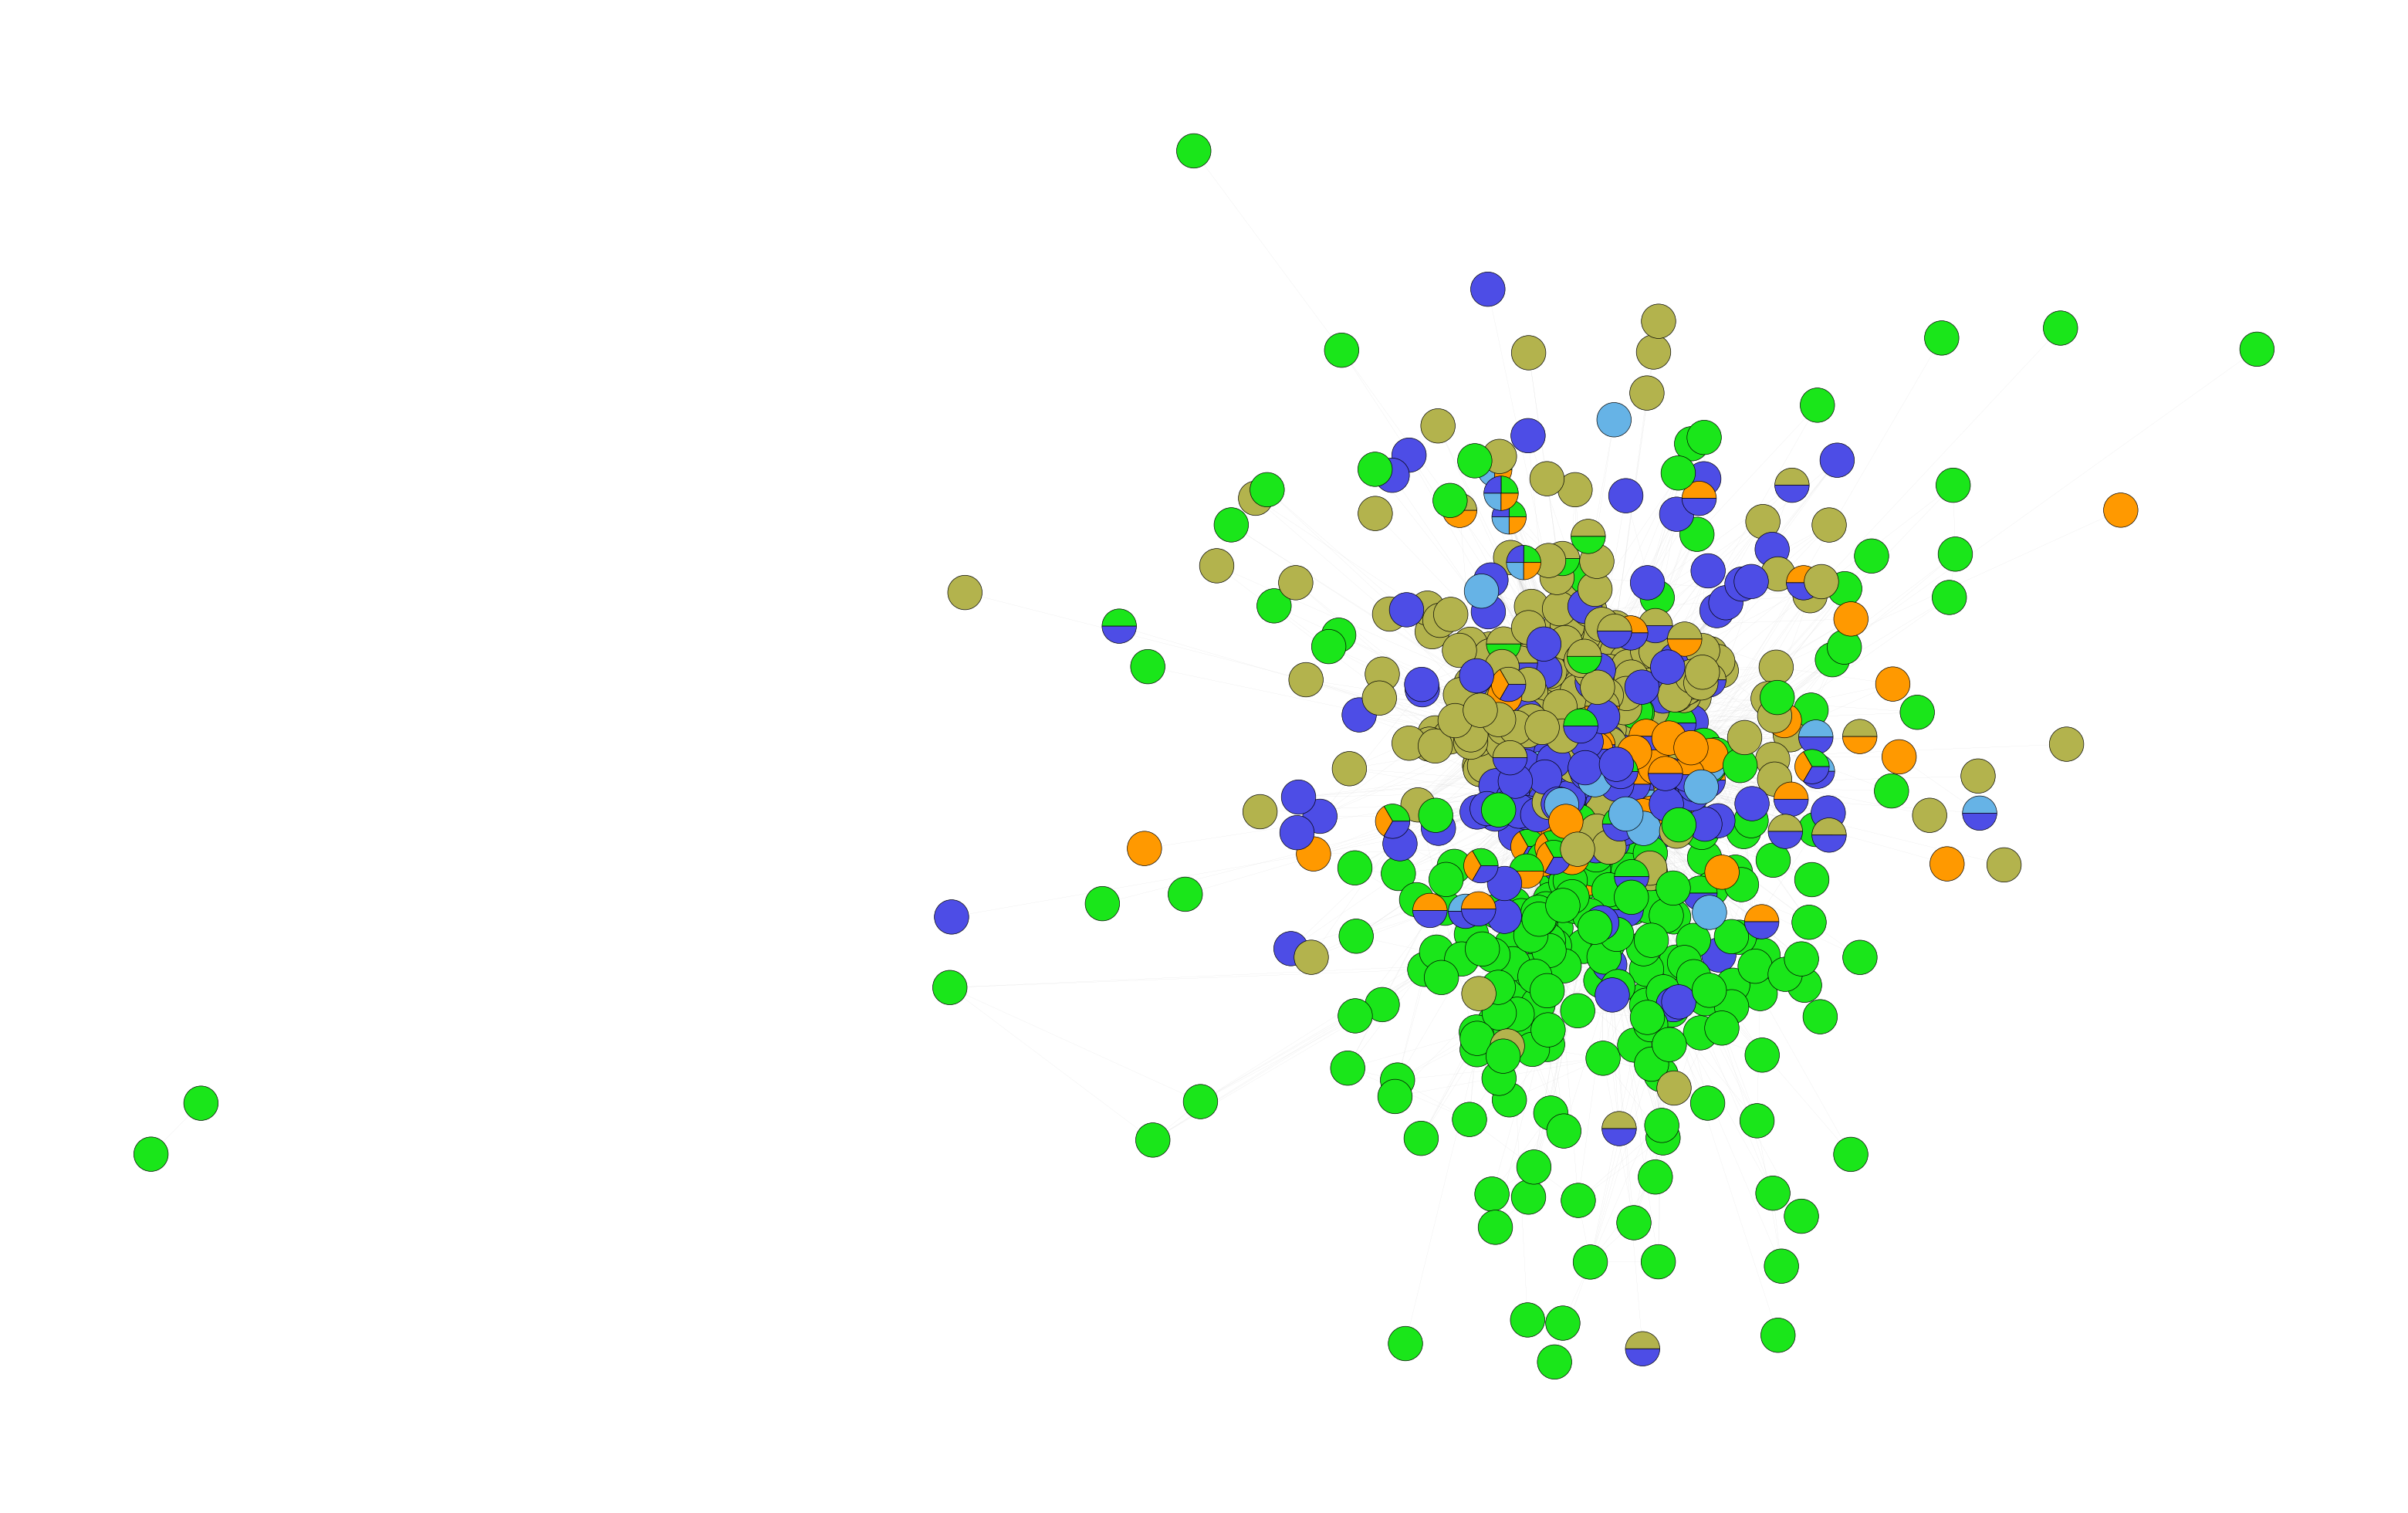

In [33]:
filename = f"Network/PrePPI_interactions_localizationcolor.png"
visualize_network(G=G_preppi, node_size=0.012, filename=filename, dist=1.05, color_by='systems', gene_dict=gene_dict, legends=False) 

In [18]:
gene_dict['AGAP3']['systems']

['Vesicle trafficking']